# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch. Except the calculation of gradients, for which we rely on the functionality provided by PyTorch. 

The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [1]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization.

In [2]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([64, 1, 28, 28])
Batch dimension (target): torch.Size([64])
Target: 5 with shape torch.Size([])


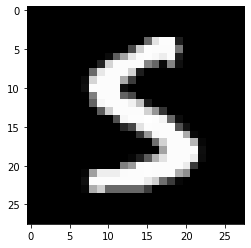

In [3]:
batch = iter(train_loader).next()
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")

With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function. For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

In [4]:
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Out model specification

In [5]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights)

In [6]:
# We flatten the digit representation so that it is consistent with the weight matrix
xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

Batch shape: torch.Size([64, 784])
Prediction on first image tensor([0.0639, 0.1458, 0.5022, 0.0610, 0.0134, 0.0525, 0.1045, 0.0142, 0.0207,
        0.0217], grad_fn=<SelectBackward>)
Corresponding classification: 2


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [7]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean()
loss_func = nll

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))

tensor(2.7704, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [8]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [9]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.09375


Now we are ready to combine it all and perform learning

In [ ]:
epochs = 4  # how many epochs to train for
lr = 0.01  # learning rate

train_losses = []
for epoch in range(epochs):

    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
                    
            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: 0.6226016513383719
Epoch: 0, B-idx: 50, Training loss: 0.5426617722902725
Epoch: 0, B-idx: 100, Training loss: 0.49561961570274093
Epoch: 0, B-idx: 150, Training loss: 0.4663262348502938
Epoch: 0, B-idx: 200, Training loss: 0.4435371878876615
Epoch: 0, B-idx: 250, Training loss: 0.4270184468199958
Epoch: 0, B-idx: 300, Training loss: 0.4155137389262856
Epoch: 0, B-idx: 350, Training loss: 0.4041890332947916
Epoch: 0, B-idx: 400, Training loss: 0.3965285414857651
Epoch: 0, B-idx: 450, Training loss: 0.38678805010595807
Epoch: 0, B-idx: 500, Training loss: 0.38139114092026694
Epoch: 0, B-idx: 550, Training loss: 0.3750149217495786
Epoch: 0, B-idx: 600, Training loss: 0.3719327908430272
Epoch: 0, B-idx: 650, Training loss: 0.36465129216533226
Epoch: 0, B-idx: 700, Training loss: 0.3624818957627201


Plot the evolution of the training loss

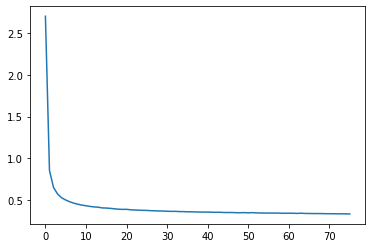

In [13]:
plt.plot(range(len(train_losses)), train_losses)

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results?
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set (for inspiration, see Line 21 above).